# Registering multiple frames to first frame

In this notebook, we investigate methods for registering all frames in a video to the first frame. 

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from ot import emd
from ot.utils import dist 
from ot.gromov import gromov_wasserstein
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from otimage import imagerep, io 
from otimage.utils import plot_maxproj_units

## Implement registration methods

In [3]:
def _normalized_dist_mtx(pts_1, pts_2, metric):
    """Return distance matrix normalized by median."""
    
    mtx_nn = dist(pts_1, pts_2, metric=metric)
    return mtx_nn / np.median(mtx_nn)


def _compute_ot(pts_1, pts_2, wts_1, wts_2):
    """Normalize weights and compute OT matrix."""
    
    # Normalize weights
    p_1 = wts_1 / np.sum(wts_1)
    p_2 = wts_2 / np.sum(wts_2)

    # Normalized distance matrix 
    c_mtx = _normalized_dist_mtx(pts_1, pts_2, 'sqeuclidean')
    
    # Compute transport plan
    return emd(p_1, p_2, c_mtx, log=True)


def _compute_gw(pts_1, pts_2, wts_1, wts_2):
    """Normalize weights and compute OT matrix."""
    
    # Normalize weights
    p_1 = wts_1 / np.sum(wts_1)
    p_2 = wts_2 / np.sum(wts_2)

    # Normalized distance matrices
    c_1 = _normalized_dist_mtx(pts_1, pts_1, metric='sqeuclidean')
    c_2 = _normalized_dist_mtx(pts_2, pts_2, metric='sqeuclidean')
    
    # Compute transport plan
    return gromov_wasserstein(c_1, c_2, p_1, p_2, 'square_loss', log=True)


def _transport_regression_poly(pts_1, pts_2, transport_mtx, degree):
    """Compute weighted polynomial regression using transport plan"""
    
    # Get pairs of points with values above threshold, and corresponding weights from P matrix
    idx_1, idx_2 = np.nonzero(transport_mtx)
    x = pts_1[idx_1]
    y = pts_2[idx_2]
    smp_wt = transport_mtx[idx_1, idx_2]

    # Use sklearn to minimize cost function
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=True)),
        ('linear', LinearRegression(fit_intercept=False))
    ])
    model.fit(x, y, linear__sample_weight=smp_wt)
   
    return model


def _em_registration(mp_1, mp_2, trans_fn, reg_fn, n_iter, pf_init=None):
    """EM-based registration method using optimal transport plan."""
    
    if pf_init is None:
        pf_init = mp_1.pts
    
    model = [None] * n_iter
    t_mtx = [None] * n_iter
    t_log = [None] * n_iter
    
    pf_pts = [pf_init] + [None] * n_iter
    
    for i in range(n_iter):
        
        # E-step: Compute OT plan between current points and target points
        t_mtx[i], t_log[i] = trans_fn(pf_pts[i], mp_2.pts, mp_1.wts, mp_2.wts)
        
        # M-step: Compute new mapping using transport plan
        model[i] =  reg_fn(mp_1.pts, mp_2.pts, t_mtx[i])
       
        # Update points 
        pf_pts[i + 1] = model[i].predict(mp_1.pts)
       
    debug = {
        'model': model,
        'pf_pts': pf_pts,
        't_mtx': t_mtx,
        't_log': t_log,
    }
    
    return model[-1], debug

    
def ot_registration(mp_1, mp_2, degree, n_iter, pf_init=None):
    """EM-based registration method using optimal transport plan."""
    
    poly_reg = partial(_transport_regression_poly, degree=degree) 
    
    return _em_registration(
        mp_1, mp_2,
        trans_fn=_compute_ot, 
        reg_fn=poly_reg,
        n_iter=n_iter,
        pf_init=pf_init
    )


def gw_registration(mp_1, mp_2, degree, n_iter, pf_init=None):
    """EM-based registration method using Gromov-Wasserstein transport plan."""
    
    poly_reg = partial(_transport_regression_poly, degree=degree) 
    
    return _em_registration(
        mp_1, mp_2,
        trans_fn=_compute_gw, 
        reg_fn=poly_reg,
        n_iter=n_iter,
        pf_init=pf_init
    )

## Load data

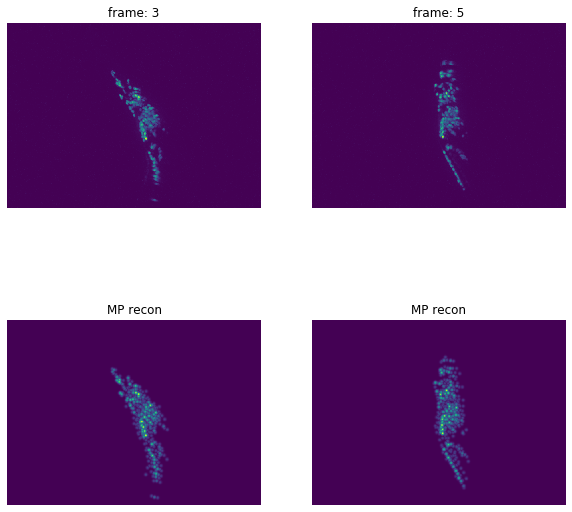

In [4]:
# Frames to load
t_start = 3
n_frames = 3
t_vals = range(t_start, t_start + n_frames)

# Load frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with io.ZimmerReader(img_path) as reader:
    units = reader.units
    img = [reader.get_frame(t) for t in t_vals]

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.h5'
with io.MPReader(mp_path) as reader:
    mps = [reader.get_frame(t) for t in t_vals]

# Reconstruct images from MPs
rec = [imagerep.reconstruct_mp_image(mp, units) for mp in mps]

# Indices to plot
k1 = 0
k2 = -1
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj_units(img[k1], units)
plt.title(f'frame: {t_vals[k1]}')
plt.axis('off')

plt.subplot(222)
plot_maxproj_units(img[k2], units)
plt.title(f'frame: {t_vals[k2]}')
plt.axis('off');

plt.subplot(223)
plot_maxproj_units(rec[k1], units)
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj_units(rec[k2], units)
plt.title('MP recon')
plt.axis('off');

## Approach 1: Register all frames to first frame directly

In [5]:
models_1 = [None] * (n_frames - 1)
debug_1 = [None] * (n_frames - 1)

for t in range(n_frames - 1):
    models_1[t], debug_1[t] = ot_registration(mps[0], mps[t + 1], degree=3, n_iter=50)

## Reconstruct frame from mapping

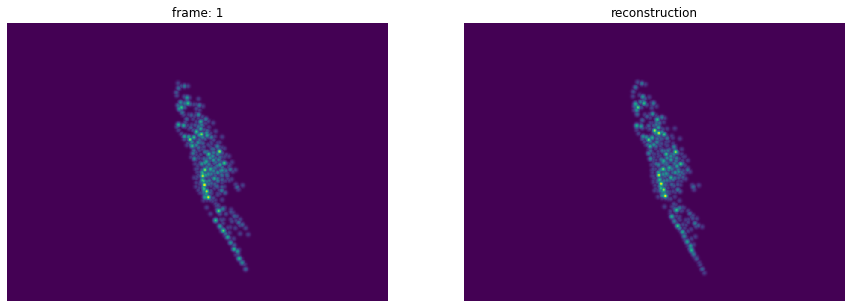

In [11]:
t = 1

t_pf_pts = models_1[t-1].predict(mps[0].pts)
t_mp = imagerep.ImageMP(t_pf_pts, mps[0].wts, mps[0].cov, mps[0].img_limits)
t_rec = imagerep.reconstruct_mp_image(t_mp, units)

plt.figure(figsize=(15, 15))

plt.subplot(121)
plot_maxproj_units(rec[t], units)
plt.title(f'frame: {t}')
plt.axis('off')
        
plt.subplot(122)
plot_maxproj_units(t_rec, units)
plt.title('reconstruction')
plt.axis('off');

## Approach 2: Register all frames to first frame using pushforward ("warm start")

In [12]:
models_2 = [None] * (n_frames - 1)
debug_2 = [None] * (n_frames - 1)

pf = [None] * n_frames
pf[0] = mps[0].pts

for t in range(n_frames - 1):
    
    models_2[t], debug_2[t] = ot_registration(mps[0], mps[t + 1], 3, 50, pf[t])
    pf[t + 1] = models_2[t].predict(mps[0].pts)

## Reconstruct frame from mapping

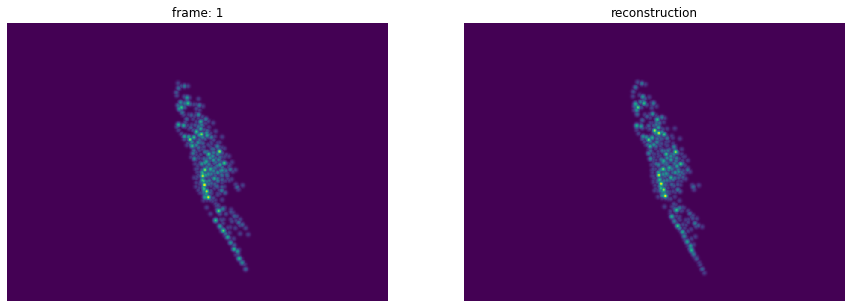

In [13]:
t = 1

t_pf_pts = models_2[t - 1].predict(mps[0].pts)
t_mp = imagerep.ImageMP(t_pf_pts, mps[0].wts, mps[0].cov, mps[0].img_limits)
t_rec = imagerep.reconstruct_mp_image(t_mp, units)

plt.figure(figsize=(15, 15))

plt.subplot(121)
plot_maxproj_units(rec[t], units)
plt.title(f'frame: {t}')
plt.axis('off')
        
plt.subplot(122)
plot_maxproj_units(t_rec, units)
plt.title('reconstruction')
plt.axis('off');